In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>''')

In [2]:
HTML('''
<style>
    .yourDiv {position: fixed;top: 100px; right: 0px; 
              background: white;
              height: 100%;
              width: 175px; 
              padding: 10px; 
              z-index: 10000}
</style>
<script>
function showthis(url) {
	window.open(url, "pres", 
                "toolbar=yes,scrollbars=yes,resizable=yes,top=10,left=400,width=500,height=500");
	return(false);
}
</script>

<div class=yourDiv>
    <h4>MENU</h4><br>
    <a href=#Data>1. Data</a><br>
    <a href=#FoodFeedOtherAcross>2. Across Farm Sizes</a><br>
    <a href=#FoodFeedOtherWithin>3. Within Farm Sizes</a><br>
    <a href=#GlobalEstimates>3. Global Estimates</a><br><br>

    <a href=#Top>Top</a><br>
    <a href="javascript:code_toggle()">Toggle Code On/Off</a><br>
    <a href=#LeftOff>Left Off Here</a><br>
    
    <h4>PROJECT NOTEBOOKS</h4><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Project_Overview'>Project Overview</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Data_Coverage'>Data Coverage</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/General_Results'>General Results</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Global_Estimate'>Global Estimates</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Crop_Diversity'>Crop Diversity</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Sensitivity_Analyses'>Sensitivity Analyses</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/'>Site Index</a><br>
</div>
''')

<a name="Top"></a>
<center><h1>General Results</h1>

In [59]:
# This page overviews our general results:

# - In our sample of {{number_countries}} countries, farms < 2 ha produce {{under_two}}% of the total food supply (global estimate of between {{under2_low}}% to {{under2_high}}% via bootstrap sampling). This smallest farm size class was the greatest producer of food compared to all other classes.<br><br>

# - Farms < 2ha were also the farm size class contributing to the largest amount of food waste (post-harvest loss, not consumer based food waste); these farms contribute to {{under_two_waste_across}}% of the total food waste in our dataset. However, this is mainly because this farm size group significantly contributes to the total crop production. <br><br>

# - This study also measures what percentage of each farm size class's crop production goes towards food, feed, processing, seed, waste, or other. Smallholders have the greatest percentage of their crop production allocated towards food versus all other farm size classes. {{under_two_food}}% of crop production on farms < 2 ha goes towards food, while {{under_two_feed}}% goes towards feed and {{under_two_waste}}% is wasted (post-harvest loss). The remainder either goes towards processing, seed, or other. The largest farm class, farms > 1000 ha, had the most amount of food waste, as {{over_thous_waste_within}}% of their crop production is wasted. This may be due to this largest farm size class has the greatest percentage of their production going towards processing.<br><br>

# - In terms of crop diversity, there is a negative trend where as farms get larger, their species richness (number of different species) declines. Species evenness remains constant across all farm sizes except the largest classes, where there is low evenness; this indicates that the larger farm sizes have higher specialization in specific crops. In general the smaller farm size classes are producing similar crops with one another and different from the larger farms, while each of the larger farm classes seem to produce a different array of crops than each other group. For more information on the analysis of crop diversity in our study, please see [this notebook](https://vinnyricciardi.github.io/farmsize_site/Html/Crop_Diversity); the general analysis is detailed below.

This page overviews our general results:<br><br>

- In our sample of 48 countries, farms < 2 ha produce 31.2% of the total food supply (global estimate of between 29.22% to 33.84% via bootstrap sampling). This smallest farm size class was the greatest producer of food compared to all other classes.<br><br>

- Farms < 2ha were also the farm size class contributing to the largest amount of food waste (post-harvest loss, not consumer based food waste); these farms contribute to 27.28% of the total food waste in our dataset. However, this is mainly because this farm size group significantly contributes to the total crop production.<br><br>

- This study also measures what percentage of each farm size class's crop production goes towards food, feed, processing, seed, waste, or other. Smallholders have the greatest percentage of their crop production allocated towards food versus all other farm size classes. 57% of crop production on farms < 2 ha goes towards food, while 13% goes towards feed and 4% is wasted (post-harvest loss). The remainder either goes towards processing, seed, or other. The largest farm class, farms > 1000 ha, had the most amount of food waste, as 7.5% of their crop production is wasted. This may be due to this largest farm size class has the greatest percentage of their production going towards processing.<br><br>

- In terms of crop diversity, there is a negative trend where as farms get larger, their species richness (number of different species) declines. Species evenness remains constant across all farm sizes except the largest classes, where there is low evenness; this indicates that the larger farm sizes have higher specialization in specific crops. In general the smaller farm size classes are producing similar crops with one another and different from the larger farms, while each of the larger farm classes seem to produce a different array of crops than each other group. 

In [18]:
import warnings
warnings.filterwarnings('ignore')
import subprocess
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
from matplotlib import colors
import copy
from collections import OrderedDict
from pivottablejs import pivot_ui  # may have to use: python setup.py install --user
import scipy.stats as st
import statsmodels.stats.api as sms
from scipy.stats import linregress
import matplotlib.patches as patches
from sklearn import linear_model
# import statsmodels.api as sm
import statsmodels.formula.api as smf
from scikits import bootstrap  # may have to pip install *.zip
    
plt.style.use('seaborn-muted')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

%matplotlib inline

In [19]:
def read_data_init(path):
    
    data = pd.read_csv(path, low_memory=False)
    data['fs_class_max'] = np.where(data['fs_class_max'].isnull(), 10000, data['fs_class_max'])
    data['Farm_Sizes'] = pd.cut(data['fs_class_max'],
                                bins=[0, 1, 2, 5, 10, 20, 50,
                                      100, 200, 500, 1000, 100000])
    
    data = data.replace(0.0, np.nan)  # there were many zero values
    
    return data

In [20]:
def clean_data(data):

    global variables
    variables = OrderedDict([('Farm_Sizes', 'Farm_Sizes'),
                             ('production_Food_kcal', 'Food'),
                             ('production_Feed_kcal', 'Feed'),
                             ('production_Seed_kcal', 'Seed'),
                             ('production_Waste_kcal', 'Waste'),
                             ('production_Processing_kcal', 'Processing'),
                             ('production_Other_kcal', 'Other')])

    data = data.loc[:, variables.keys()]
    data.columns = variables.values()

    return data

In [21]:
def piv(data, func=np.nansum):

    pivot = pd.pivot_table(data,
                           index=['Farm_Sizes'],
                           values=variables.values()[1:],
                           aggfunc=func)

    return pivot

In [22]:
def perc(data, how='within'):

    if how is 'within':

        pivot = piv(data)
        pivot = pivot.transpose()

        for variable in pivot.columns:
            pivot[variable] = pivot[variable] / pivot[variable].sum()

        return pivot.transpose()


    elif how is 'cumsum':

        pivot = piv(data)

        for variable in pivot.columns:
            pivot[variable] = pivot[variable] / pivot[variable].sum()

        pivot = pivot.cumsum(axis=0)

        return pivot


    elif how is 'across':

        pivot = piv(data)

        for variable in pivot.columns:
            pivot[variable] = pivot[variable] / pivot[variable].sum()

        return pivot.transpose()

    else:

        print 'Require how argument'

In [23]:
try:
    PATH = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/FarmSize_data_fullyProcessed.csv'
    data_orig = read_data_init(PATH)
except:
    PATH = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/FarmSize_data_fullyProcessed.csv'
    data_orig = read_data_init(PATH)

df = clean_data(data_orig)
# df['Farm_Sizes'] = df['Farm_Sizes'].astype(str)

In [24]:
df_within = perc(df, how='within')
df_across = perc(df, how='across')
df_cumsum = perc(df, how='cumsum')
df_across_prod = pd.DataFrame(df_across.mean(), columns=['All']).reset_index()
df_raw = piv(df)

In [25]:
tmp1 = df_within.copy()
tmp1['Type'] = 'Within'

tmp2 = df_across.copy()
tmp2 = tmp2.transpose()
tmp2['Type'] = 'Across'

tmp3 = df_cumsum.copy()
tmp3['Type'] = 'Cumsum'

tmp4 = df_raw.copy()
tmp4['Type'] = 'Raw'

tmp5 = df_across_prod.copy()
tmp5['Type'] = 'All'

tmp = pd.concat([tmp1, tmp2, tmp3, tmp4])
tmp = tmp.reset_index()
# tmp = pd.merge(tmp, tmp5, on=['Farm_Sizes', 'Type'], how='outer')
tmp['Farm_Sizes'] = tmp['Farm_Sizes'].astype(str).str.replace('(', '')
tmp['Farm_Sizes'] = tmp['Farm_Sizes'].astype(str).str.replace(']', '')

In [26]:
under_two = round(100 * df_cumsum.iloc[1,1], 1)
under_fifty = round(100 * df_cumsum.iloc[5,1], 1)
onehund_twohund = round(100 * (df_across.iloc[1, 7]), 1)

one_food = round(100 * df_within.iloc[0,1], 1)
one_waste = round(100 * df_within.iloc[0,5], 1)
two_food = round(100 * df_within.iloc[1,1], 1)
two_waste = round(100 * df_within.iloc[1,5], 1)
one_feed =  round(100 * df_within.iloc[0,0], 1)
two_feed =  round(100 * df_within.iloc[1,0], 1)

tmp_txt = data_orig.query("production_Food == production_Food")
number_countries = number_countries = len(tmp_txt.NAME_0.unique())
number_records = len(tmp_txt)
under_two_food = int(round((one_food + two_food) / 2, 0))
under_two_waste = int(round((one_waste + two_waste) / 2, 0))
under_two_feed = int(round((one_feed + two_feed) / 2, 0))

under_two_waste_across = round(100 * df_cumsum.iloc[1, -1], 2)
under_two_food_within = round(100 * ((df_within.iloc[0, 1] + df_within.iloc[1, 1]) / 2), 2)
over_thous_waste_within = round(100 * df_within.iloc[-1, -1], 2)

<a name="Data"></a>
<h2>Data</h2><br>

For an overview of the data, see the [data coverage notebook](https://vinnyricciardi.github.io/farmsize_site/Html/Data_Coverage).<br><br>
Click the table to interactively explore the data. Use 'type' to change whether you are looking at the percentage of crop produced for each category 'within' a farm size group, 'across' groups, via a 'cumulative' percentage across groups, or raw kcal produced. Use the dropdown labeled 'Food' to recalculate based on another production category. 

In [60]:
# pivot_ui(tmp, 
#          rows=['Farm_Sizes'], 
#          cols=['Type'], 
#          aggregatorName='Sum', 
#          vals=['Food'],
#          rendererName='Col Heatmap', 
#          colOrder= "value_a_to_z")
# tmp.to_csv('/Users/Vinny_Ricciardi/Downloads/pivot_test.csv')

# Enable for pivot table interactivitity within this Jupyter notebook
# Here's a nice example of how to change the html output file for prettier output when in html: 
# https://pivottable.js.org/examples/montreal_2014.html

In [62]:
# gen_path = '/Users/Vinny_Ricciardi/Documents/Scripts/Python/Projects/FarmSize_Global/virtualenvironment/app_/JupyterSite/'
gen_path = '/home/vinny_ricciardi/Documents/Scripts/Python/Projects/FarmSize_Global/virtualenvironment/app_/JupyterSite/'
html_path = gen_path + 'Notebooks/pivottablejs.html'
img_path = gen_path + 'Html/pivot_pic.png'

subprocess.call("wkhtmltoimage {} {}".format(html_path, img_path), shell=True);

In [29]:
%%html
<a href="https://vinnyricciardi.github.io/farmsize_site/Html/pivottablejs" 
rel="some text">
<img src=https://vinnyricciardi.github.io/farmsize_site/Html/pivot_pic.png 
    alt="Drawing" style="width: 700px;"/>

<a name="FoodFeedOtherAcross"></a>
<h2>Food Feed Other by Farm Size</h2><br>

In [30]:
t = round(100 * df_across.iloc[1,-2], 1)

This plot shows the percentage that each farm size contributes to each category (e.g., food, feed, other, etc.). For example, farms between 500 to 1000 ha produce {{round(100 * df_across.iloc[1,-2], 1)}}% of the total food supply in our sample.

In [31]:
def plot_stacked_bar(data, how='within', fig_=True, ax=None):

    txt1 = ['Feed', 'Food', 'Other', 'Processing', 'Seed', 'Waste']
    txt2 = ['< 1', '1 to 2', '2 to 5', '5 to 10', '10 to 20',
            '20 to 50', '50 to 100', '100 to 200', '200 to 500',
            '500 to 1000', '> 1000']
    txt3 = ['< 1', '2 to 5', '10 to 20', '50 to 100', '200 to 500', '> 1000']

    if how is 'within':

        legend_txts = copy.copy(txt1)
        labels_txts = copy.copy(txt2)
        cmap = cm.get_cmap('Set3')
        kind = 'bar'

    elif how is 'across':

        legend_txts = copy.copy(txt2)
        labels_txts = copy.copy(txt1)
        cmap = cm.get_cmap('YlGnBu')
        kind = 'bar'

    elif how is 'cumsum':

        legend_txts = copy.copy(txt1)
        labels_txts = copy.copy(txt3)
        cmap = cm.get_cmap('Set3')
        kind = 'area'
    
    else:
        pass
    
    if fig_ is True:
        
        fig = plt.figure(figsize=[10, 5], facecolor='white')
        ax = fig.add_subplot(111)
    
    else:
        pass

    data.plot(kind=kind,
              stacked=True,
              cmap=cmap,
              alpha=0.9,
              linewidth=0,
              grid=False,
              ax=ax)
    
    # Axis main
    ax.set_axis_bgcolor("#d6d7e5")
    ax.set_clip_on(False)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Legend
    legend_txts_r = copy.deepcopy(legend_txts)
    legend_txts_r.reverse()
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[::-1], labels[::-1],
                       loc='center left',
                       frameon=1,
                       bbox_to_anchor=(1, 0.5))

    for i in xrange(len(legend_txts_r)):
        legend.get_texts()[i].set_text(legend_txts_r[i])

    frame = legend.get_frame()
    frame.set_color('white')

    # Axis particulars
    ax.set_xticklabels(labels_txts)
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)

    if how is 'within':
        ax.set_xlabel('Farm Sizes (ha)')
        ax.set_ylabel('Percentage\n')
        ax.set_ylim([0, 1])
        ax.set_title('Type of production per farm size\n', fontsize=12)

    elif how is 'across':
        ax.set_xlabel('Category')
        ax.set_ylabel('Percentage\n')
        ax.set_ylim([0, 1])
        ax.set_title('Type of production across farm size\n', fontsize=12)
        
    elif how is 'cumsum':
        ax.set_xlabel('Farm Sizes (ha)')
        ax.set_ylabel('Percentage\n')
        ax.set_title('Type of production per farm size: Cumulative\n', fontsize=12)

    if fig_ is True:
        return plt.show()

    else:
        return ax

In [32]:
def factor_plot(data, id_var='Farm_Sizes'):
    
    data = pd.melt(data, id_vars='Farm_Sizes')
    data = data.loc[data['value'] > 0.5] 
    data['log'] = np.log(data['value'])
    
    fs_order = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
                '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
                '(500, 1000]', '(1000, 100000]']
    
    if id_var is 'Farm_Sizes':
        
        col = 'variable'
        x = 'Farm_Sizes'
        y = 'log'
        order = fs_order

    else:
        
        data = data.sort_values('Farm_Sizes')
        data['Farm_Sizes'] = pd.Categorical(data['Farm_Sizes'], fs_order)
        data = data.sort_values('Farm_Sizes')
        col = 'Farm_Sizes'
        x = 'variable'
        y = 'log'
        order = None

    g = sns.factorplot(x=x, y=y,
                       col=col, 
                       data=data,
                       kind='box',
                       col_wrap=4,
                       color='#55a868',
                       fliersize=1,
                       aspect = 1,
                       order=order)

    g.fig.subplots_adjust(wspace=0.2, hspace=0.3)

    titles = data.variable.unique()
    
    fs_txt = ['< 1', '1 to 2', '2 to 5', '5 to 10', '10 to 20',
              '20 to 50', '50 to 100', '100 to 200', '200 to 500',
              '500 to 1000', '> 1000']
    
    if id_var is 'Farm_Sizes':
        
        for ax, title in zip(g.axes.flat, titles):
            
            ax.set_title(title)
            ax.set_ylabel('Production \n ln (kcal)')
            ax.set_xticklabels(fs_txt)
            ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
            ax.set_xlabel('\nFarm Sizes (ha)')
        
    else:
        
        for ax, title in zip(g.axes.flat, fs_txt):
            
            ax.set_title(title)
            ax.set_ylabel('Production \n ln (kcal)')
            ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
            ax.set_xlabel('\nPoduction Category')

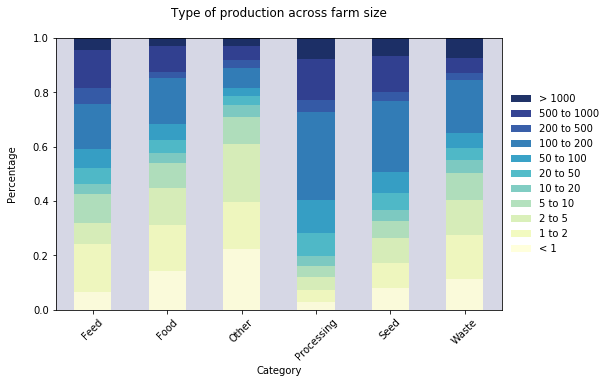

In [33]:
plot_stacked_bar(df_across, how='across', fig_=True)

This plot also shows the percentage that each farm size contributes to each category but in cumulative percentages. For example, farms under 2 ha produce {{under_two}}% of the total food supply in our sample and farms 50 ha and under produce {{under_fifty}}% of the total food supply in our sample. Again, here is a [link](https://vinnyricciardi.github.io/farmsize_site/Html/pivottablejs) to an interactive pivot table so you can explore the data in more detail.

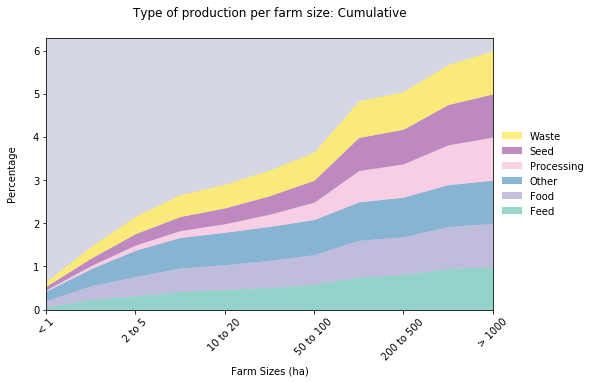

In [34]:
plot_stacked_bar(df_cumsum, how='cumsum', fig_=True)

In order to better understand whether there are differences between the farm size groups, these boxplots show the total amount of crops produced (in logged kcal for standardization). Across all production categories (e.g., food, feed, other, etc.) there are no visual differences in the means and confidence intervals. But, there are many of outliers in each plot that indicate high variance.

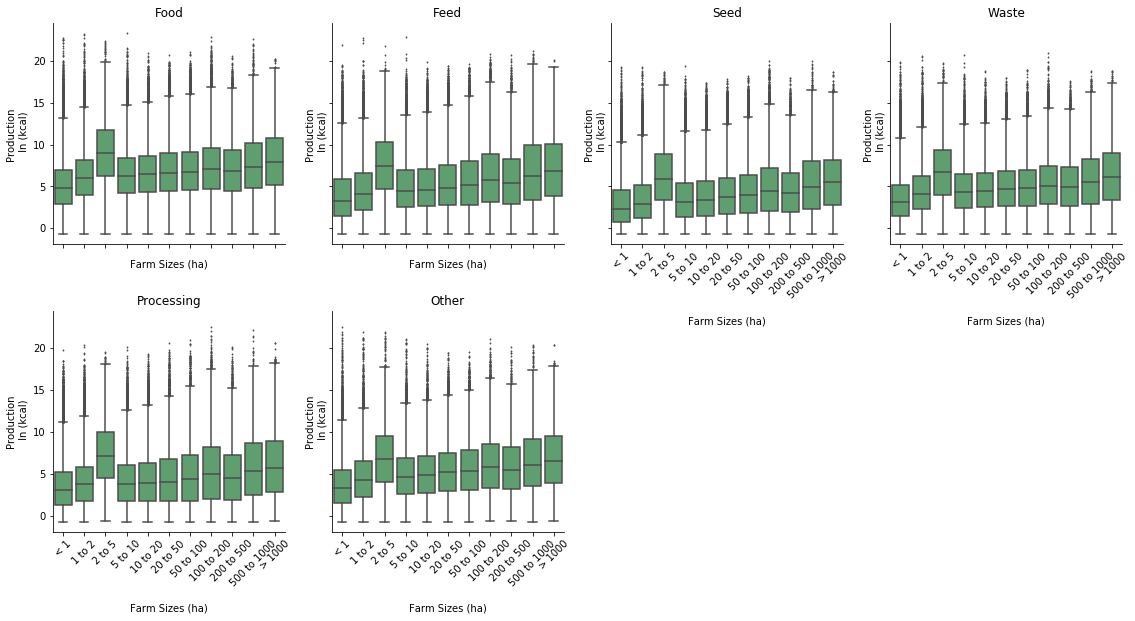

In [35]:
factor_plot(df, id_var='Farm_Sizes')

Since many of the plots have large variance and skewness, here are density plots comparing farm size classes per each category. We can see that the largest farm size group has different distributions from the remaining groups.

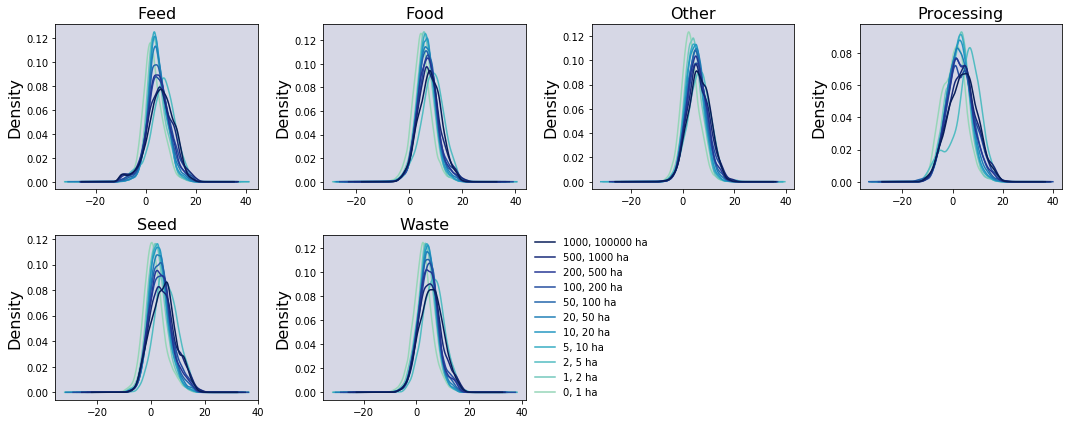

In [36]:
colors_ = ['#97d6b9',
           '#73c8bd',
           '#52bcc2',
           '#37acc3',
           '#2498c1',
           '#1f80b8',
           '#2165ab',
           '#234da0',
           '#253795',
           '#172978',
           '#081d58']

tmp = df.copy()
tmp = pd.melt(tmp, id_vars='Farm_Sizes')
tmp = tmp.dropna()
cols = np.sort(tmp['variable'].unique())
fs = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
      '(10, 20]', '(20, 50]', '(50, 100]', 
      '(100, 200]', '(200, 500]', '(500, 1000]', 
      '(1000, 100000]']

fig = plt.figure(figsize=[15, 6])

for j in xrange(len(cols)):
    
    ax = fig.add_subplot(2, 4, j+1)
    ax.set_axis_bgcolor("#d6d7e5")
    ax.grid(alpha=0.0)

    tmp1 = tmp.loc[tmp['variable'] == cols[j]]

    for i in xrange(len(fs)):

        tmp2 = tmp1.loc[tmp1['Farm_Sizes'] == fs[i]]
        np.log(tmp2['value']).plot(kind='kde', 
                                   label=fs[i][1:-1] + ' ha',
                                   color=colors_[i],
                                   ax=ax)
        
    ax.set_title(cols[j], fontsize=16)
    ax.set_ylabel('Density', fontsize=16)
    
legend = ax.legend(frameon=True, fontsize=12)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::-1], labels[::-1],
                   loc='center left',
                   frameon=1,
                   bbox_to_anchor=(1, 0.5))
frame = legend.get_frame()
frame.set_color('#ffffff')

plt.tight_layout()
plt.show()

Since our sample is very large ({{number_countries}} countries which comprise of {{number_records}} total records due to subnational units and crop types) we cannot use p-values to determine significance between the amount of production by varying farm sizes.<br><br>
To circumvent the large dataset issue, the effect size was used to determine differences between farm sizes rather than statistical significance. Cohen's d was calculated via taking the (mean of farmsize 1 - mean of farmsize 2) / (standard deviation of farmsize 1) then taking the absolute value. The relative significance was calculated by thresholds according to [Sullivan and Feinn 2012](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3444174/).

Where the Cohen d's effect size values correspond to percent non-overlapping observations, as in:


| **Relative Size** | **Effect Size**| **Percentile**| **% of Non-overlap**|
|---------------	|:-------------:|:-----------:	|:-------------------:	|
|               	|      0      	|     50    	|         0         	|
| Small         	|     0.2     	|     58    	|         15        	|
| Medium        	|     0.5     	|     69    	|         33        	|
| Large         	|     0.8     	|     79    	|         47        	|
|               	|     1.0     	|     84    	|         55        	|
|               	|     1.5     	|     93    	|         71        	|
|               	|     2.0     	|     97    	|         81        	|

In [37]:
def cohens_d(data1, data2, how='within'):

    cols = data1.columns
    check = []
    
    for i in xrange(0, len(cols)):
        
        for j in xrange(1, len(cols)):
            
            col_name = str(cols[i]) + '_' + str(cols[j])
            col_name_r = str(cols[j]) + '_' + str(cols[i])

            if col_name in check:
                
                pass

            elif cols[i] is cols[j]:
                
                pass

            else:
                
                pass
                
            data1[col_name] = ((data1[cols[i]] - data1[cols[j]]) / data2[cols[i]]).abs() 
                                #np.sqrt(data2[cols[i]]**2 + data2[cols[j]]**2)).abs()  # if want to change cohens d
            check.append(col_name)
            check.append(col_name_r)


    data = data1.iloc[:, len(cols):]

    data = data.reset_index()

    if how is 'across':
        
        data = pd.melt(data, id_vars='index', value_name='cohens_d')
        
    elif how is 'within':
        
        data = data.transpose()
        data = data.reset_index()
        data = data.iloc[:, :-1]
        cols = list(data1.transpose().columns[:-1])
        cols.insert(0, 'Category')
        data.columns = cols
        data = data.iloc[1:, :]
        data = pd.melt(data, id_vars='Category', value_name='cohens_d')

    else:
        print 'Check how arg'
        
    data['cohens_d_level'] = np.where(data['cohens_d'] <= 0.2, 'small',
                                      np.where(data['cohens_d'] >= 0.8, 'large',
                                               'medium'))

    return data

In [38]:
# def cohens_interp(func=np.mean, index='index'):
    
#     tmp = pd.pivot_table(out, 
#                          index=index, 
#                          columns='cohens_d_level', 
#                          values='cohens_d', 
#                          aggfunc=func)   
    
#     tmp = tmp.reset_index()
#     tmp = tmp.dropna()

#     try:
#         tmp = tmp.sort('large', ascending=False)
#         tmp.columns = ['Category', 'large d', 'medium d', 'small d']

#     except:
#         tmp = tmp.sort('medium', ascending=False)
#         tmp.columns = ['Farm Sizes', 'medium d', 'small d']
    
#     return tmp

<a name="Large_fs_data_issue"></a>
Here are the biggest differences between farm size groups. As expected, there are large coefficients (effect size) between small and large farm classes. Note, the largest farm size class (> 1000 ha had minimal data points, which seemed to cause distributions were very different than the other classes. For now, this class was omitted in the below results).

In [39]:
def plot_cohensd_heatmap(data, ax=None):
    
    fs = ['0, 1',
          '1, 2',
          '2, 5',
          '5, 10',
          '10, 20',
          '20, 50',
          '50, 100',
          '100, 200',
          '200, 500',
          '500, 1000']
    
    cats = ['Food', 'Other', 'Processing', 'Seed', 'Waste']

    hm = data.copy()
    hm = hm.loc[:, ['fs1', 'fs2', 'Cohens d']]
    hm2 = hm.loc[:, ['fs2', 'fs1', 'Cohens d']]
    hm2.columns = hm.columns
    hm = pd.concat([hm, hm2])

    hm['fs1'] = hm['fs1'].str.replace('(', '')
    hm['fs1'] = hm['fs1'].str.replace(')', '')
    hm['fs2'] = hm['fs2'].str.replace('(', '')
    hm['fs2'] = hm['fs2'].str.replace(')', '')
    hm = hm.dropna()
    hm['Cohens d'] = hm['Cohens d'].astype(float)
    
    hm = pd.pivot_table(hm, 
                        index=['fs1'], 
                        columns=['fs2'], 
                        values='Cohens d', 
                        fill_value=0., 
                        aggfunc=np.nanmean)

    try:
        
        hm = hm.loc[:, fs]
        hm = hm.reset_index()
        hm['fs1'] = pd.Categorical(hm['fs1'], fs)
        
    except:
        
        hm = hm.loc[:, cats]
        hm = hm.reset_index()
        hm['fs1'] = pd.Categorical(hm['fs1'], cats)

    hm = hm.sort_values('fs1')
    hm = hm.set_index('fs1')
    hm = hm.iloc[1:, :]
  
    sns.heatmap(hm, cmap=cm.get_cmap('BuPu'), ax=ax);
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45);
    ax.set(xlabel='', ylabel='');

    
def plot_cohensd_barplot(data, ax=None, how='across'):
    
    fs = ['(1, 2)',
          '(2, 5)',
          '(5, 10)',
          '(10, 20)',
          '(20, 50)',
          '(50, 100)',
          '(100, 200)',
          '(200, 500)',
          '(500, 1000)']
    
    if how is 'across':

        t = pd.pivot_table(data, index=['Category'], values='Cohens d', aggfunc=np.sum)
        t = t.reset_index()
        t = t.sort_values('Cohens d', ascending=False)
        order = t['Category'].unique()
        sns.barplot(data['Category'], data['Cohens d'], order=order, color='#94D3CA', errcolor='grey', ax=ax);

    else:
        
        t = pd.pivot_table(data, index=['Farm_Sizes'], values='Cohens d', aggfunc=np.sum)
        t = t.reset_index()
        t = t.sort_values('Cohens d', ascending=False)
        order = t['Farm_Sizes'].unique()
        sns.barplot(data['Farm_Sizes'], data['Cohens d'], order=order, color='#94D3CA',  errcolor='grey', ax=ax);
        
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45);
    ax.set(xlabel='', ylabel='Cohens d');

    
def plot_cohens_all(data, how='across'):

    fig = plt.figure(figsize=[15,5])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    plot_cohensd_heatmap(data, ax=ax1);
    plot_cohensd_barplot(data, how=how, ax=ax2);
    ax1.set_title("Pairwise effect size\n", fontsize=14);
    ax2.set_title("Mean effect size per grouping\n", fontsize=14);
    
    return plt.show()
def cohens_full_func(data, how='across'):

    data = data.loc[data['Farm_Sizes'] != '(1000, 100000]']
    data['Farm_Sizes'] = data['Farm_Sizes'].astype(str)

    means = pd.pivot_table(data, columns='Farm_Sizes', aggfunc=np.nanmean)
    sds = pd.pivot_table(data, columns='Farm_Sizes', aggfunc=np.nanstd)

    if how is 'across':
        
        tmp = cohens_d(means, sds, how=how)
        tmp['Farm_Sizes'] = tmp['Farm_Sizes'].str.replace(']', ')')
        tmp['Farm_Sizes'] = tmp['Farm_Sizes'].str.replace('_', ' and ')
        tmp.columns = ['Category', 'Farm sizes compared', 'Cohens d', 'Relative effect size']
        tmp = tmp.sort_values('Cohens d', ascending=False)
        t = tmp['Farm sizes compared'].str.split(' and ', expand=True)
        t.columns = ['fs1', 'fs2']
        tmp = pd.concat([tmp, t], axis=1) 

    else:
        
        means = means.transpose()
        sds = sds.transpose()
        tmp = cohens_d(means, sds, how=how)
        tmp.columns = ['Category', 'Farm_Sizes', 'Cohens d', 'Relative effect size']
        tmp = tmp.sort_values('Cohens d', ascending=False)
        t = tmp['Category'].str.split('_', expand=True)
        t.columns = ['fs1', 'fs2']
        tmp = pd.concat([tmp, t], axis=1) 

    
    return plot_cohens_all(tmp, how=how)

On average, the largest effect size (differences) between farm sizes were in the seed and processing categories. The 100 to 200 ha class had the greatest differences between their contributions to each food, feed, other cateogry compared to other farm size classes contributions.

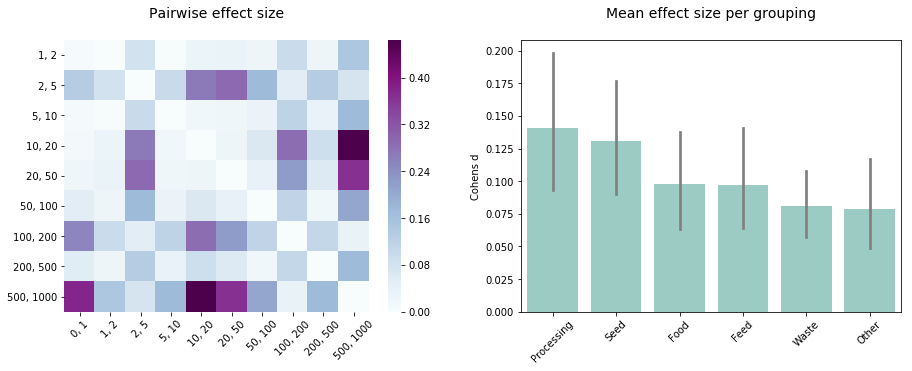

In [40]:
cohens_full_func(df, how='across')

<a name="FoodFeedOtherWithin"></a>
<h2>Food Feed Other within Farm Size Groups</h2><br>

This plot shows the percentage of Food, Feed, Seed, Waste, Processing, and Other for each farm size category. For example, {{one_food}} % of the crops produced for farms under 1 ha is food, while {{one_waste}}% of their crop production is waste.

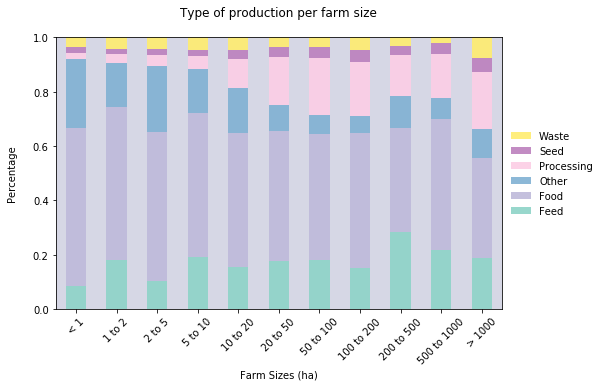

In [41]:
plot_stacked_bar(df_within, how='within', fig_=True)

In order to better understand whether there are differences within how a given farm size group allocates their crop production, these boxplots show the total amount of crops produced (in logged kcal for standardization). As in the previous analysis, across all farm size categories there are no visual differences in the means and confidence intervals. But, there are many of outliers in each plot that indicate high variance.

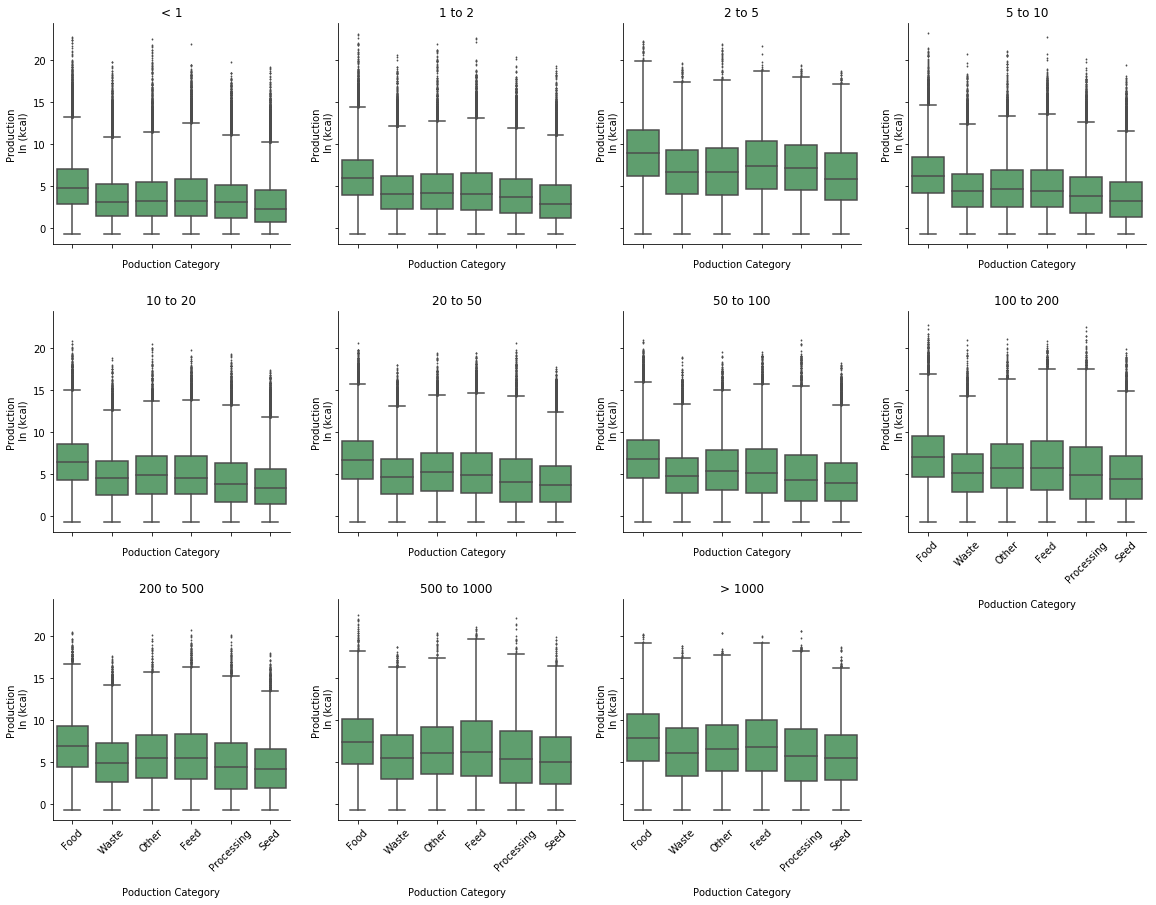

In [42]:
factor_plot(df, id_var='variable')

Since many of the plots have large variance and skewness, here are density plots comparing farm size classes per each category. We can see that the largest farm size group has different distributions from the remaining groups.

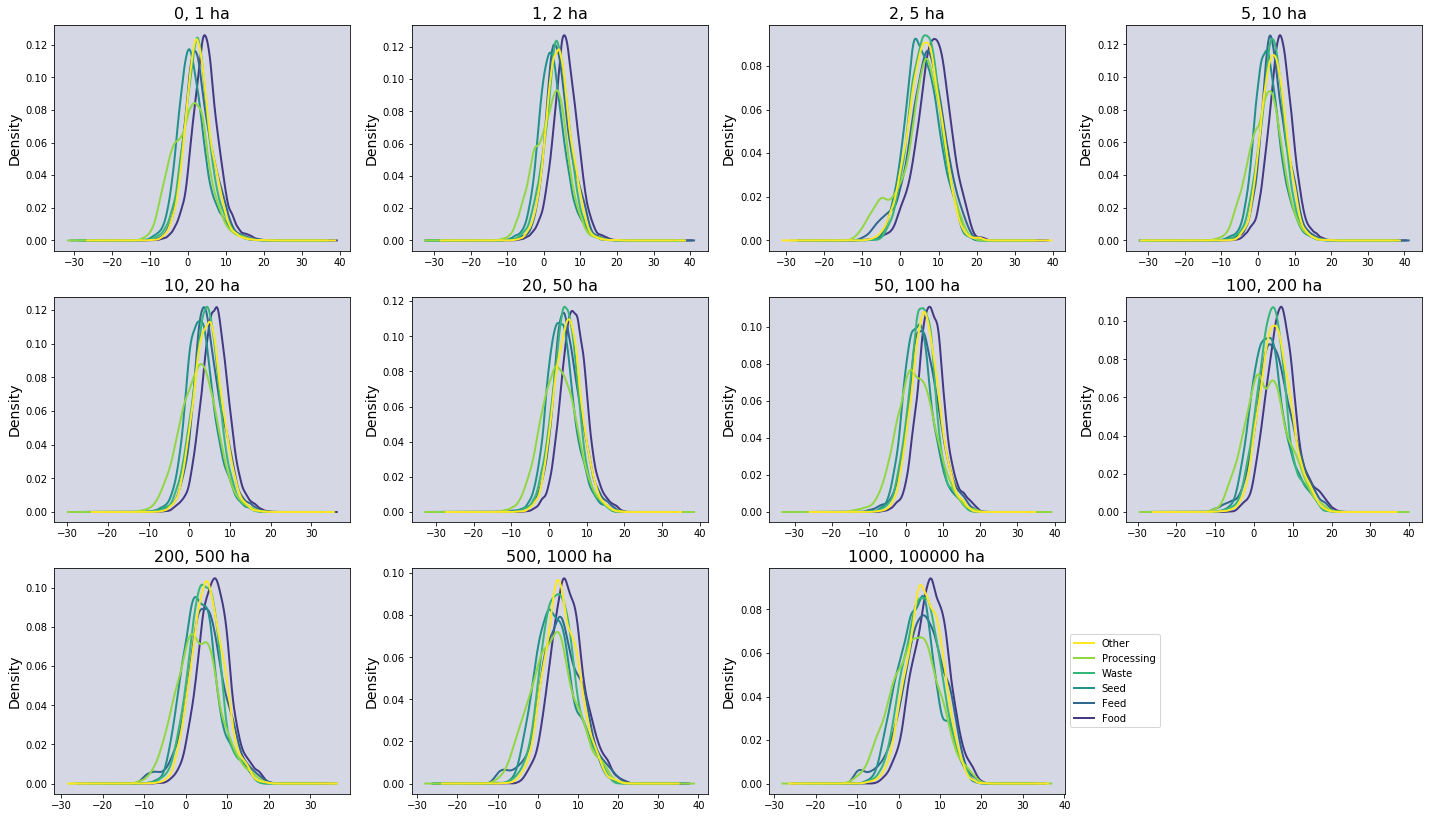

In [43]:
tmp = df.copy()
fs = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
      '(10, 20]', '(20, 50]', '(50, 100]', 
      '(100, 200]', '(200, 500]', '(500, 1000]', 
      '(1000, 100000]']

tmp = tmp.dropna()
cols = tmp.columns

cmap = cm.get_cmap('viridis', 7)    # Set3 and YlGnBu are used throughout
colors_ = []

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors_.append(colors.rgb2hex(rgb))


fig = plt.figure(figsize=[20,15])

for j in xrange(len(fs)):
    
    tmp1 = tmp.loc[tmp['Farm_Sizes'] == fs[j]]

    ax = fig.add_subplot(4, 4, j+1)
    ax.set_axis_bgcolor("#d6d7e5")
    ax.grid(alpha=0.0)

    for i in xrange(1, len(cols)):
        np.log(tmp1[cols[i]]).plot(kind='kde', 
                                   label=cols[i],
                                   color=colors_[i],
                                   linewidth=2,
                                   ax=ax)
    
    ax.set_title(fs[j][1:-1] + ' ha', fontsize=16)
    ax.set_ylabel('Density', fontsize=14)


legend = ax.legend(frameon=True, fontsize=12)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::-1], labels[::-1],
                   loc='center left',
                   frameon=1,
                   bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

We calculated the effect size for the differences within each farm size group, but across production cateogries (e.g., food, feed, other).
There were only medium differences in effect size when looking at how each farm size group allocated their production. Most of the differences were between food and the other categories.

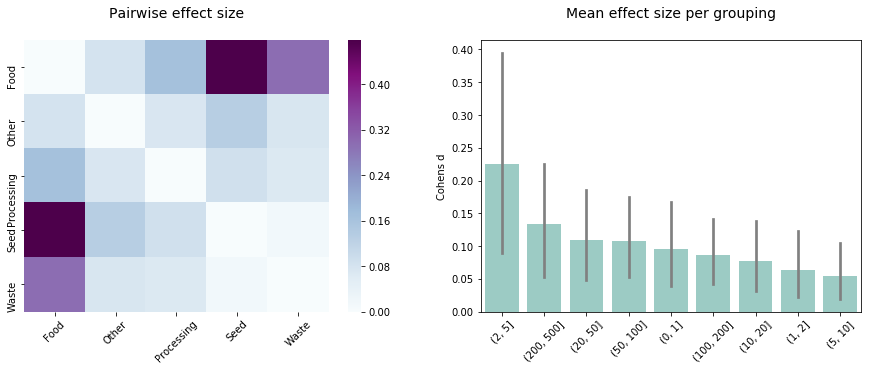

In [44]:
cohens_full_func(df, how='within')

<a name="GlobalEstimates"></a>
<h2>Global Estimates</h2><br>

To construct a global estimate based on our sample, we first resampled using the jacknife and boostrapping techniques. 
Jacknife:
We calculated the total food production while iteratively subsetting each country. Then we take the mean and confidence intervals for each farm size class. The jacknife resampling technique allows us to understand the error and bias in our results and construct confidence intervals around that bias.

Bootstrap:
... to be filled in

Main difference, the jacknife resulted in narrower CIs mainly because of the variable's distribution, hence the non-parametric boostrapping method used (accelerated bias-corrected percentile limits method) will give more conservative estimates on production ranges per farm size class.

In [45]:
def jacknife_prep(path, how='under2'):
    
    data = pd.read_csv(PATH, low_memory=False)
    data['fs_class_max'] = np.where(data['fs_class_max'].isnull(), 10000, data['fs_class_max'])
    data = data.replace(0.0, np.nan)  # there were many zero values
    
    if how is 'under2':

        data['Farm_Sizes'] = pd.cut(data['fs_class_max'],
                                    bins=[0, 2, 5, 10, 20, 50,
                                          100, 200, 500, 1000, 100000])
        
        fs_order = ['(0, 2]', '(2, 5]', '(5, 10]', '(10, 20]', 
                    '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
                    '(500, 1000]', '(1000, 100000]']

        fs_txt = ['< 2', '2 to 5', '5 to 10', '10 to 20',
                  '20 to 50', '50 to 100', '100 to 200', '200 to 500',
                  '500 to 1000', '> 1000']
        
    else:
        
        data['Farm_Sizes'] = pd.cut(data['fs_class_max'],
                                        bins=[0, 1, 2, 5, 10, 20, 50,
                                              100, 200, 500, 1000, 100000])
        
        fs_order = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
                    '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
                    '(500, 1000]', '(1000, 100000]']
                        
        fs_txt = ['< 1', '1 to 2', '2 to 5', '5 to 10', '10 to 20',
                  '20 to 50', '50 to 100', '100 to 200', '200 to 500',
                  '500 to 1000', '> 1000']
    
    # data['production_Food_kcal'] = data['kcal'] * data['Production_fix']  
    # use if want all types or other type boostrap estimate
    
    variables = ['NAME_0',  
                 'Farm_Sizes', 
                 'production_Food_kcal']
    
    data['Farm_Sizes'] = data['Farm_Sizes'].astype(str)
    data = data.loc[:, variables]
    data = data.dropna()
    
    return data, fs_order, fs_txt

In [46]:
data, fs_order, fs_txt = jacknife_prep(PATH, how='under1')

In [47]:
dictionary = dict(zip(fs_order, range(0, len(fs_order))))  # used to circumvent categorical indexing
data['ix'] = data['Farm_Sizes'].map(dictionary)

In [48]:
def jacknife(data, variable='production_Food_kcal'):
    
    dictionary = dict(zip(fs_order, range(0, len(fs_order))))  # used to circumvent categorical indexing
    data['ix'] = data['Farm_Sizes'].map(dictionary)

    out = pd.DataFrame(columns=['NAME_0', 'Farm_Sizes', 'ix'])
    
    fsize = []
    ixs = []

    for f, ix in zip(data['Farm_Sizes'].unique(), data['ix'].unique()):
        
        out2 = pd.DataFrame(columns=['NAME_0', 'Farm_Sizes', 'ix'])

        tmp = data.loc[data['Farm_Sizes'] == f]

        tmp = tmp.sort_values('ix')
        
        names = []
        
        for i in tmp.NAME_0.unique():
            
            tmp2 = tmp[tmp['NAME_0'] != i]

            pivot = pd.pivot_table(tmp2, 
                                   index=['ix'],
                                   values=variable, 
                                   aggfunc=np.nansum).reset_index()

            pivot['NAME_0'] = i
            pivot['Farm_Sizes'] = f
            pivot['ix'] = ix
            out2 = pd.concat([out2, pivot])
            
        out2['tot_mean'] = np.nanmean(out2[variable])
        out2['mj_m_2'] = (out2[variable] - out2['tot_mean'])**2
        out2['s'] = np.sqrt(np.nansum(out2['mj_m_2']) / float(len(tmp.NAME_0.unique()) - 1))
        out2['se'] = out2['s'] / np.sqrt(len(tmp.NAME_0.unique()) - 1)
        out2['ci_high'] = out2['tot_mean'] + (2.09 * out2['se'])  # 2.09 is the upper 0.25% of the t-distribution
        out2['ci_low'] = out2['tot_mean'] - (2.09 * out2['se'])
        
        out = pd.concat([out, out2])
    
        out['country_mean'] = out['production_Food_kcal']
    
    out = out.drop('production_Food_kcal', 1)
    out['country_mean_p'] = (out['country_mean'] / data['production_Food_kcal'].sum())
    out['country_ci_high_p'] = out['country_mean_p'] * np.mean(out['ci_high']/ out['tot_mean'])
    out['country_ci_low_p'] = out['country_mean_p'] * np.mean(out['ci_low']/ out['tot_mean'])
    out['fs_mean_p'] = (out['tot_mean'] / data['production_Food_kcal'].sum())
    out['fs_ci_high_p'] = out['fs_mean_p'] * np.mean(out['ci_high']/ out['tot_mean'])
    out['fs_ci_low_p'] = out['fs_mean_p'] * np.mean(out['ci_low']/ out['tot_mean'])
    
    pivot = pd.pivot_table(out,
                          index=['Farm_Sizes', 'ix'],
                          values=['fs_mean_p', 'fs_ci_high_p', 'fs_ci_low_p']).reset_index()

    pivot.columns = ['Farm_Sizes', 'ix', 'ci_high', 'ci_low', 'mean']

    return out, pivot

In [49]:
df_jk, prods = jacknife(data)

To do:
-  Discuss details of jacknife estimate:<br>
Note that it may not be the best estimator to use because: assumes normal distribution to calculate SE and doesn't work well with smaller datasets (here the estimate is taken at the cvountry level, hence n=53)
- Fixed the CI (need to write methods out). it should be mu ± 1.96 * SE, where <br>
s = sqrt( sum(muj - mu)^2 / 19 )<br>
se = s / sqrt(19)<br>
ci = mu ± se<br>
note: since production_kcal is log-normal, log(mu, muj)then compute

This chart shows the results of the jacknife sample. Each bar represents the range of food production by each farm size class.

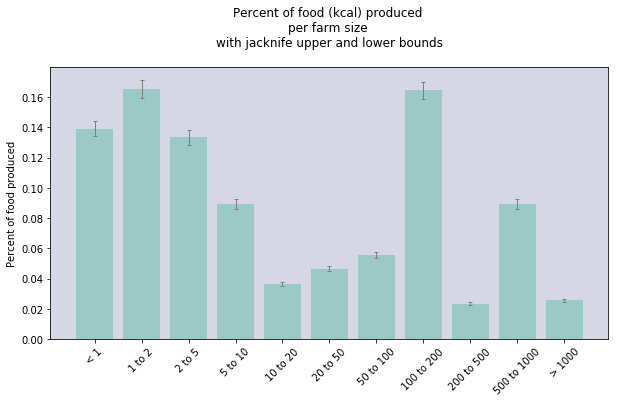

In [50]:
def barplot_resample(data, title_insert='jacknife'):
    
    prods = data.sort_values('ix')
    yerr = np.c_[prods['mean'] - prods['ci_low'], prods['ci_high'] - prods['mean']].T

    fig = plt.figure(figsize=[10, 5])
    ax = fig.add_subplot(111)
    ax.bar(range(len(prods['mean'])), prods['mean'], 
            yerr=yerr,
            color='#9BCAC4',
            error_kw=dict(ecolor='gray', 
                          lw=1, 
                          capsize=2, 
                          capthick=1))

    ax.set_xticklabels
    ax.set_axis_bgcolor("#d6d7e5")
    ax.grid(alpha=0.0)
    ax.set_xticks(range(len(prods['mean'])))
    ax.set_xticklabels(fs_txt, rotation=45)
    ax.set_ylabel('Percent of food produced')
    ax.set_title('Percent of food (kcal) produced '
                 '\nper farm size '
                 '\nwith {} upper and lower bounds\n'.format(title_insert))

    plt.show()
    
barplot_resample(prods, title_insert='jacknife')

In [51]:
# def plot_ranges(data, variable='country_mean_p',
#                 title='Jacknife distributions \nacross farm size classes\n'):

#     fig = plt.figure(figsize=[8, 5])
#     # fs = prods['Farm_Sizes'].unique()
#     # fs = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
#     #       '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
#     #       '(500, 1000]', '(1000, 100000]']

#     fs = ['(0, 2]', '(2, 5]', '(5, 10]', 
#           '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
#           '(500, 1000]', '(1000, 100000]']

#     colors_ = ['#97d6b9',
#               '#73c8bd',
#               '#52bcc2',
#               '#37acc3',
#               '#2498c1',
#               '#1f80b8',
#               '#2165ab',
#               '#234da0',
#               '#253795',
#               '#172978',
#               '#081d58'] 

#     ax = fig.add_subplot(111)

#     for i in xrange(len(fs[:])): 
#         tmp = prods[prods['Farm_Sizes'] == fs[i]]
#         label = fs[i][1:-1]
#         tmp[variable].plot(kind='kde', label=label, color=colors_[i], ax=ax)

#     legend = ax.legend(frameon=True, fontsize=12, loc='upper right')
#     frame = legend.get_frame()
#     frame.set_color('#d6d7e5')
#     ax.set_axis_bgcolor("#d6d7e5")
#     ax.grid(alpha=0.0)
#     ax.set_clip_on(False)
#     ax.tick_params(axis='x', labelsize=12)
#     ax.tick_params(axis='y', labelsize=12)
#     ax.set_xlabel('\nFood Production (% kcal)', fontsize=12)
#     ax.set_title(title, fontsize=14)
#     fig.tight_layout()
    
#     return plt.show()

In [52]:
# prods = df_jk.copy()
# plot_ranges(prods, variable='country_mean_p', title='Jacknife distributions \nacross farm size classes\n')

<a name="Boostrap"></a>
<h3>Bootstrap Estimates</h3>

In [53]:
def bootstrap_results(data, method='bca', how='noncumulative'):

    out = pd.DataFrame(columns=['Farm_Sizes', 'mean', 'ci_low', 'ci_high'])

    for f in data['Farm_Sizes'].unique():

        farms = []
        lows = []
        highs = []
        means = []

        tmp = data.loc[data['Farm_Sizes'] == f]
        pivot = pd.pivot_table(tmp, 
                               index=['NAME_0'],
                               values='production_Food_kcal', 
                               aggfunc=np.nansum).reset_index()
        arr = np.log(np.array(pivot['production_Food_kcal']))

        l, h = bootstrap.ci(arr, statfunction=np.nanmedian, alpha=0.05, n_samples=10000,
               method=method, output='lowhigh', epsilon=0.001, multi=False,
               _iter=True)
        
        if how is 'cumulative':

            if f is data['Farm_Sizes'].unique()[0]:
                fs_m = np.nansum(np.exp(arr)) / np.nansum(data['production_Food_kcal'])
            else:
                fs_m = fs_m + (np.nansum(np.exp(arr)) / np.nansum(data['production_Food_kcal']))

        else:
            fs_m = np.nansum(np.exp(arr)) / np.nansum(data['production_Food_kcal'])
            
        low = fs_m - (l / np.nansum(arr))
        high = fs_m + (h / np.nansum(arr))

        lows.append(low)
        highs.append(high)
        farms.append(f)
        means.append(fs_m)

        out_t = pd.concat([pd.DataFrame(farms, columns=['Farm_Sizes']),
                           pd.DataFrame(lows, columns=['ci_low']),
                           pd.DataFrame(highs, columns=['ci_high']),
                           pd.DataFrame(means, columns=['mean'])], axis=1)
        out = pd.concat([out, out_t], axis=0)

    out['ix'] = range(0, len(data['Farm_Sizes'].unique()))
    out['ci_low'] = np.where(out['ci_low'] < 0., 0., out['ci_low'])

    return out

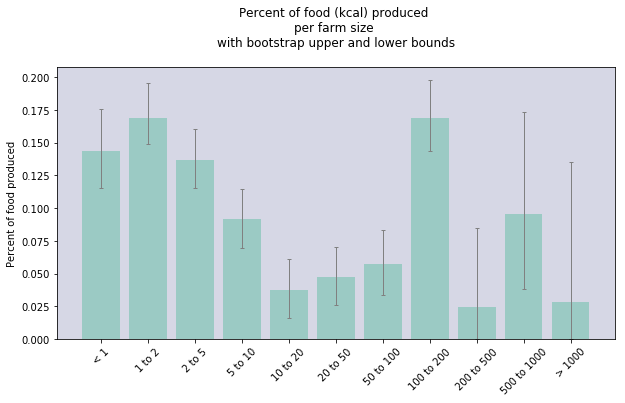

In [54]:
prods = bootstrap_results(data, how='noncumulative')
barplot_resample(prods, title_insert='bootstrap')

The boostrap was calculated using the accelerated bias-corrected percentile limits method. Basically, this boostrapping method is non-parametric and uses the proportion of resampled values that fall above the non-resampled mean to estimate the population distribution. Here, I used the natural log of the value before running hte boostrap procedure, since the distribution was near log-normal; without this transformation the confidence intervals were systematically shifted upwards. With the transformation they are now centered around the mean.

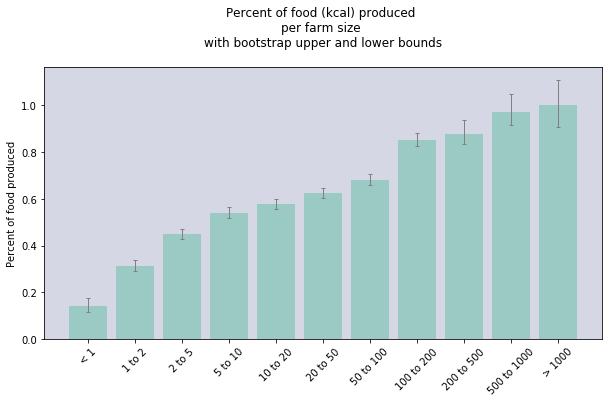

In [55]:
prods_cumulative = bootstrap_results(data, how='cumulative')
barplot_resample(prods_cumulative, title_insert='bootstrap')

In [56]:
under2_low = round(100 * prods_cumulative.iloc[1, 2], 2)
under2_high = round(100 * prods_cumulative.iloc[1, 1], 2)

In [57]:
prods_cumulative

,Farm_Sizes,ci_high,ci_low,mean,ix
0,"(0, 1]",0.175889,0.115502,0.143283,0
0,"(1, 2]",0.338437,0.292235,0.312264,1
0,"(2, 5]",0.473056,0.427510,0.448660,2
0,"(5, 10]",0.563314,0.519042,0.540179,3
0,"(10, 20]",0.601042,0.556469,0.577511,4
0,"(20, 50]",0.648165,0.603650,0.625026,5
0,"(50, 100]",0.708144,0.659001,0.682217,6
0,"(100, 200]",0.879753,0.826037,0.851034,7
0,"(200, 500]",0.936246,0.832609,0.875915,8
0,"(500, 1000]",1.049185,0.914019,0.971566,9


<a name="LeftOff"></a>
<h3>Left Off</h3>

To do:
- Clean up this notebook written descriptions
- Finish sensitivity analyses (namely family farm bias)
- Can we make a simple mode to estimate production of food by farm size? Check out [this notebook](https://vinnyricciardi.github.io/farmsize_site/Html/Global_Estimate) for recent efforts.
    - food produced (per farm size) = amount food produced (in kcal) + % operational holdings (per given farm size - note % area would be better, but China and other large countries do not have info available)<br><br>